# 1. Problem

**Histopathologic Cancer Detection**

In this project, we will work on a binary image classification problem where we will identify metastatic cancer cells in small image patches taken from larger digital pathology scans via machine learnign models.

## About the Dataset

The dataset consists of a large number of small pathology images to classify. It provides `train dataset` which we will use to train our models and a `test dataset` with which our model will predict.

This dataset is a cleaner version (duplicates have been removed) of the [original PCam dataset](https://github.com/basveeling/pcam).

[LEARN MORE](https://www.kaggle.com/c/histopathologic-cancer-detection/data)

## Import Libraries

In [1]:
! pip install google
! pip install pandas
! pip install matplotlib tensorflow
! pip install pillow
! pip install -U scikit-learn
! pip install -U keras

DEPRECATION: Loading egg at /opt/homebrew/lib/python3.11/site-packages/api-0.0.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /opt/homebrew/lib/python3.11/site-packages/api-0.0.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /opt/homebrew/lib/python3.11/site-packages/api-0.0.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /opt/homebrew/lib/python3.11/site-packages/api-0.0.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour chan

In [65]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras.metrics import AUC, Precision, Recall
from keras.optimizers import SGD

import os

from PIL import Image
train_on_gpu = True

## Load dataset

Visit [here](https://www.kaggle.com/discussions/general/74235) to learn how to download data from Kaggle to google colab

In [3]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
! pip install -q kaggle

DEPRECATION: Loading egg at /opt/homebrew/lib/python3.11/site-packages/api-0.0.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [5]:
# upload kaggle credentials
uploaded = files.upload()

In [6]:
! mkdir ~/.kaggle

In [7]:
# copy kaggle.json to .kaggle
! cp kaggle.json ~/.kaggle/

In [8]:
# change permissions of the file
! chmod 600 ./.kaggle/kaggle.json

In [9]:
# check if everything works well
! kaggle datasets list

ref                                                             title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rahulvyasm/netflix-movies-and-tv-shows                          Netflix Movies and TV Shows                          1MB  2024-04-10 09:48:38          19320        417  1.0              
jainaru/thyroid-disease-data                                    Thyroid Disease Data                                 3KB  2024-05-10 12:06:31           1307         32  1.0              
sahirmaharajj/school-student-daily-attendance                   School Student Daily Attendance                      2MB  2024-04-29 19:29:56           4669         97  1.0              
sahirmaharajj/college-exam-results-sat                          C

In [10]:
# download dataset
! kaggle competitions download -c histopathologic-cancer-detection

In [11]:
! mkdir histopathologic-cancer-detection

In [12]:
# unzip data
! unzip histopathologic-cancer-detection.zip -d histopathologic-cancer-detection

In [13]:
train_images_folder = "histopathologic-cancer-detection/train"
test_images_folder = "histopathologic-cancer-detection/test"

In [14]:
# Load the dataset
data_file = "histopathologic-cancer-detection/train_labels.csv"
data_sample_file = "histopathologic-cancer-detection/sample_submission.csv"
data = pd.read_csv(data_file)
data_sample = pd.read_csv(data_sample_file)

# 2. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In [15]:
df = data.copy()
df_sample = data_sample.copy()

**Print data shape**

In [16]:
df.shape

(220025, 2)

In [17]:
df_sample.shape

(57458, 2)

In [18]:
df.head(5)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [19]:
df.tail(5)

,id,label
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0
220024,a81f84895ddcd522302ddf34be02eb1b3e5af1cb,1


In [20]:
df_sample.head(5)

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


**Print datatypes of dataset**

In [21]:
df.dtypes

id       object
label     int64
dtype: object

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [23]:
df.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [24]:
df['label'].unique()

array([0, 1])

In [25]:
df['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

### Data Cleaning & Preprocessing

**Missing (null) Values**

In [26]:
# count NaN
df.isna().sum()

id       0
label    0
dtype: int64

**Drop duplicates (if any)**

In [27]:
df.drop_duplicates(inplace=True)

**Data so far ...**

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


### Visualize label distribution and images

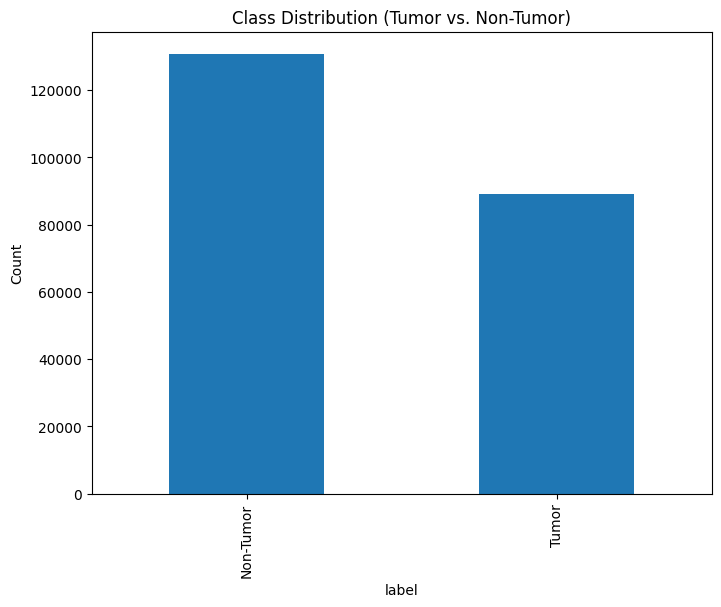

In [29]:
label_counts = df['label'].value_counts()

plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar')
plt.title('Class Distribution (Tumor vs. Non-Tumor)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Tumor', 'Tumor'])
plt.show()

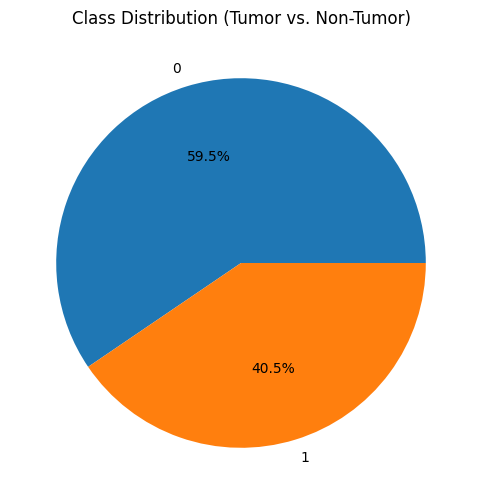

In [30]:
plt.figure(figsize=(8, 6))
label_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Class Distribution (Tumor vs. Non-Tumor)')
plt.ylabel('')  # Remove y-label in pie charts
plt.show()

In [31]:
print("Number of training images: {}".format(len(os.listdir(train_images_folder))))
print("Number of test images: {}".format(len(os.listdir(test_images_folder))))

Number of training images: 220025
Number of test images: 57458


In [32]:
train_images = os.listdir(train_images_folder)
test_images = os.listdir(test_images_folder)

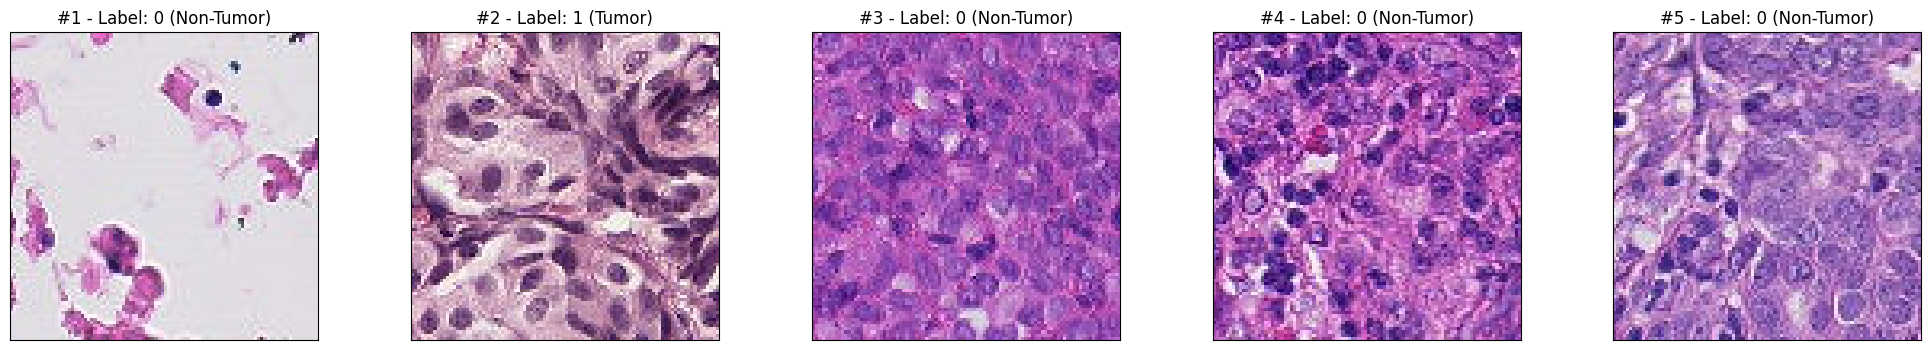

In [33]:
fig = plt.figure(figsize=(25, 4))
for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
    im = Image.open(train_images_folder + "/" + train_images[i])
    plt.imshow(im)
    label = "1 (Tumor)" if df['label'][i] == 1 else f"0 (Non-Tumor)"
    ax.set_title(f'#{i+1} - Label: {label}')


#### Image preprocessing

**Split the data**

In [34]:
train_data, validation_data = train_test_split(df, test_size=0.2, random_state=42)

In [35]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 176020 entries, 2425 to 121958
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      176020 non-null  object
 1   label   176020 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 4.0+ MB


In [36]:
validation_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44005 entries, 107796 to 119838
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      44005 non-null  object
 1   label   44005 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ MB


### Image data augumentation

Augument train dataset to provide many variations for effective model training.

In [37]:
train_datagen = ImageDataGenerator(
    rotation_range=180,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    brightness_range=(0.8,1.2)
)

validation_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

Add `.tif` extension to file name

In [38]:
train_data = train_data.astype(str)
validation_data = validation_data.astype(str)
train_data['id'] += '.tif'
validation_data['id'] += '.tif'

In [39]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_images_folder,
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

Found 176020 validated image filenames belonging to 2 classes.


In [40]:
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_data,
    directory=train_images_folder,
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

Found 44005 validated image filenames belonging to 2 classes.


In [41]:
test_data = df_sample.astype(str)
test_data['id'] += '.tif'

In [42]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory=test_images_folder,
    x_col='id',
    y_col='label',
    shuffle=False,
    target_size=(96, 96),
    batch_size=32
)

Found 57458 validated image filenames belonging to 1 classes.


# 3. CNN Model & Analysis

There are various popular CNN architectures that have prove effective for various tasks, including medical image analysis, some fo which are `VGG`, `LeNet-5`, `AlexNet`, `Inception`, `ResNet`, etc.

For this project we will use a shallow version of `VGG`.

In [43]:
def CNN(model_):
    model = model_(layers=[
      Conv2D(16, (3, 3), padding='same', input_shape=(96, 96, 3)),
      BatchNormalization(),
      Activation('relu'),

      Conv2D(16, (3, 3), padding='same'),
      BatchNormalization(),
      Activation('relu'),
      MaxPooling2D((3, 3)),

      Conv2D(32, (3, 3), padding='same'),
      BatchNormalization(),
      Activation('relu'),

      Conv2D(32, (3, 3), padding='same'),
      BatchNormalization(),
      Activation('relu'),
      MaxPooling2D((3, 3)),

      # Flattens the feature maps into a 1D vector before feeding them to the fully connected layers (Classifiction layer).
      Flatten(),

      # Connected layers (Classifiction layer)
      Dense(128),
      BatchNormalization(),
      Activation('relu'),
      Dropout(0.5),
      Dense(1, activation='sigmoid')
    ])

    return model

def get_pred_df(y_ids: list, y_pred: np.ndarray):

    df = pd.DataFrame(columns=['id', 'label'])

    df['id'] = y_ids
    df['label'] = np.round(y_pred.flatten()).astype('int')

    return df

#### Evaluation metrics

1. **Precision:** This answers the question: "Of all the samples the model predicted as positive (tumor), how many were actually positive?" High precision means the model has few false positives.

2. **Recall (Sensitivity):** This answers: "Of all the actual positive (tumor) samples, how many did the model correctly identify?" High recall means the model has few false negatives. Given the critical nature of cancer detection, it is better to have some false positives (non-tumors identified as tumors) than to have false negatives (tumors identified as non-tumors). Hence, We will prioritize recall.

3. **AUC-ROC (Area Under the Receiver Operating Characteristic Curve):** A crucial metric for medical applications, especially with imbalanced datasets. It measures the model's ability to discriminate between positive and negative classes across different thresholds. A higher AUC-ROC indicates better discrimination.

    The AUC is the area under this ROC curve. It ranges from 0 to 1, where:

    1. **AUC = 0.5:** The model's predictions are no better than random guessing (equivalent to flipping a coin). The ROC curve would be a diagonal line.
    2. **AUC = 1.0:** Perfect discrimination. The model correctly classifies all positive and negative instances. The ROC curve would hug the top left corner.
    3. **AUC > 0.5:** Indicates the model is better than random guessing. The higher the AUC, the better the model's ability to distinguish between the two classes.

#### SGD Model

In [44]:
SGD_model = CNN(Sequential)
optimizer = SGD(learning_rate=0.01)
SGD_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[Precision(), Recall(), AUC()], steps_per_execution=1)

# fit model
SGD_history = SGD_model.fit(
    train_generator,
    validation_data = validation_generator,
    epochs = 6
)


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6


/opt/homebrew/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 618s 112ms/step - auc: 0.8469 - loss: 0.4795 - precision: 0.7442 - recall: 0.6996 - val_auc: 0.8906 - val_loss: 0.4420 - val_precision: 0.8747 - val_recall: 0.6039
Epoch 2/6
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 540s 98ms/step - auc: 0.8947 - loss: 0.3998 - precision: 0.8000 - recall: 0.7450 - val_auc: 0.8711 - val_loss: 0.8461 - val_precision: 0.9862 - val_recall: 0.1526
Epoch 3/6
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 576s 105ms/step - auc: 0.9109 - loss: 0.3689 - precision: 0.8242 - recall: 0.7684 - val_auc: 0.8733 - val_loss: 0.6196 - val_precision: 0.9202 - val_recall: 0.4362
Epoch 4/6
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 614s 112ms/step - auc: 0.9220 - loss: 0.3451 - precision: 0.8359 - recall: 0.7891 - val_auc: 0.8393 - val_loss: 0.8360 - val_precision: 0.9702 - val_recall: 0.3217
Epoch 5/6
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 540s 98ms/step - auc: 0.9283 - loss: 0.3309 - precision: 0.8460 - recall: 0.7992 - val_auc: 0.8937 - val_loss: 0.7048 - val_precision: 0.9805 - val_re

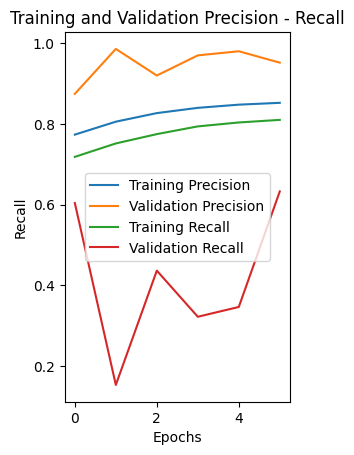

In [45]:
plt.subplot(1, 2, 2)

plt.plot(SGD_history.history['precision'], label='Training Precision')
plt.plot(SGD_history.history['val_precision'], label = 'Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.title('Train vs Validation Loss Per Epoch')


plt.plot(SGD_history.history['recall'], label='Training Recall')
plt.plot(SGD_history.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Precision - Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.show()

From the graph above, we can observe that, as we go up the epoch, there was a steady increase in the precision (0.74 - 0.85) and recall (0.7 - 0.81) values for the training data, indicating **very few false positives** predictions. Also, we observed a flunctuating precision (0.87 - 0.95) and recall (0.6 - 0.63) reading for the validation data.

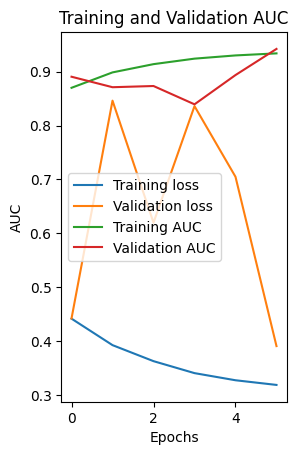

In [46]:
# AUC & loss plot
plt.subplot(1, 2, 2)

plt.plot(SGD_history.history['loss'], label='Training loss')
plt.plot(SGD_history.history['val_loss'], label = 'Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Validation Loss Per Epoch')


plt.plot(SGD_history.history['auc'], label='Training AUC')
plt.plot(SGD_history.history['val_auc'], label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.show()

From the graph above we can see that the **AUC** for both the Training (0.85 - 0.93) and Validation (0.89 - 0.9) which infers that the model is an excellent discriminator between the positive (tumor) and negative (non-tumor) classes.

On the loss curve, we observe a steady decrease for the training dataset, while a flunctuating decrease can be seen for the validation data.

In [47]:
test_generator.reset()
label_pred_1 = SGD_model.predict(test_generator)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 38s 21ms/step


In [48]:
model_pred_df_1 = get_pred_df(df_sample['id'], label_pred_1)
model_pred_df_1

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0
...,...,...
57453,061847314ded6f81e1cd670748bfa2003442c9c7,0
57454,6f3977130212641fd5808210015a609c658dcbff,0
57455,46935f247278539eca74b54d07d666efb528a753,0
57456,a09bcae08a82120183352e0e869181b2911d3dc1,0


In [64]:
# save to csv
model_pred_df_1.to_csv("result_1.csv", index=False)

### Hyperparamenter Tunning

Although the SGD model is promising, it would be nice to try some tunning by reducing the learning rate for the **SGD model** and trying a more advanced optimizer such as **Adaptive Moment Estimation (Adam)**

#### SGD Model (2nd iteration)

We will reduce the learning rate of the SGD model to mitigate the flunctuating loss function for the validation dataset.

In [49]:
SGD_model_2 = CNN(Sequential)
optimizer = SGD(learning_rate=0.001) # lower learning rate
SGD_model_2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[Precision(), Recall(), AUC()])

# fit model
SGD_model_2_history = SGD_model_2.fit(
    train_generator,
    validation_data = validation_generator,
    epochs = 6
)

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 518s 94ms/step - auc_1: 0.7885 - loss: 0.5694 - precision_1: 0.6768 - recall_1: 0.6334 - val_auc_1: 0.8557 - val_loss: 0.5391 - val_precision_1: 0.8528 - val_recall_1: 0.5063
Epoch 2/6
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 502s 91ms/step - auc_1: 0.8549 - loss: 0.4667 - precision_1: 0.7496 - recall_1: 0.7119 - val_auc_1: 0.8797 - val_loss: 0.4606 - val_precision_1: 0.8594 - val_recall_1: 0.5841
Epoch 3/6
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 485s 88ms/step - auc_1: 0.8734 - loss: 0.4361 - precision_1: 0.7751 - recall_1: 0.7262 - val_auc_1: 0.8349 - val_loss: 0.4983 - val_precision_1: 0.6935 - val_recall_1: 0.7083
Epoch 4/6
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 489s 89ms/step - auc_1: 0.8824 - loss: 0.4203 - precision_1: 0.7899 - recall_1: 0.7309 - val_auc_1: 0.8913 - val_loss: 0.4278 - val_precision_1: 0.8537 - val_recall_1: 0.6229
Epoch 5/6
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 478s 87ms/step - auc_1: 0.8881 - loss: 0.4111 - precision_1: 0.7963 - recall_1: 0.7370 - val_au

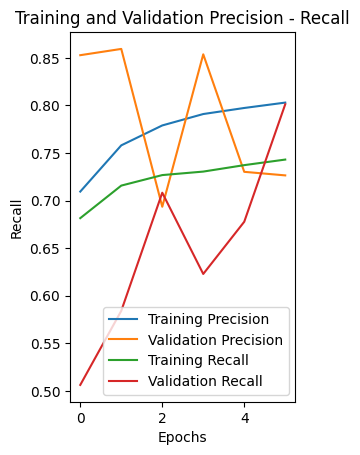

In [51]:
# Precision & Recall plot
plt.subplot(1, 2, 2)

plt.plot(SGD_model_2_history.history['precision_1'], label='Training Precision')
plt.plot(SGD_model_2_history.history['val_precision_1'], label = 'Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.title('Train vs Validation Loss Per Epoch')


plt.plot(SGD_model_2_history.history['recall_1'], label='Training Recall')
plt.plot(SGD_model_2_history.history['val_recall_1'], label='Validation Recall')
plt.title('Training and Validation Precision - Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.show()

From the graph above, we can observe that, as we go up the epoch, there was a steady increase in the precision (0.68 - 0.8) and recall (0.63 - 0.74) values for the training data, indicating **very few false positives** predictions. Also, we observed a flunctuating and decreasing precision (0.85 - 0.72) and but marked increase in recall (0.51 - 0.8) reading for the validation data.

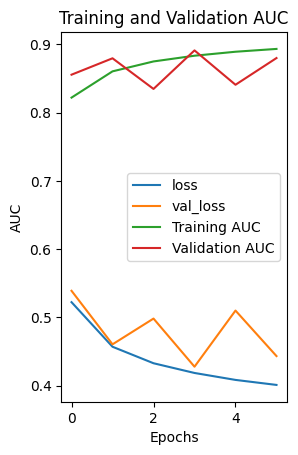

In [52]:
# AUC & Loss plot
plt.subplot(1, 2, 2)

plt.plot(SGD_model_2_history.history['loss'], label='loss')
plt.plot(SGD_model_2_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Validation Loss Per Epoch')


plt.plot(SGD_model_2_history.history['auc_1'], label='Training AUC')
plt.plot(SGD_model_2_history.history['val_auc_1'], label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.show()

From the graph above we can see that the **AUC** for both the Training (0.79 - 0.89) and Validation (0.86 - 0.89) which infers that the model is an excellent discriminator between the positive (tumor) and negative (non-tumor) classes.

On the loss curve, we observe a slight decrease (0.57 - 0.41) for the training dataset, while a flunctuating decrease (0.54 - 0.44) can be seen for the validation data.

In [53]:
test_generator.reset()
label_pred_2 = SGD_model_2.predict(test_generator)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step


In [54]:
model_pred_df_2 = get_pred_df(df_sample['id'], label_pred_2)
model_pred_df_2

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,1
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0
...,...,...
57453,061847314ded6f81e1cd670748bfa2003442c9c7,0
57454,6f3977130212641fd5808210015a609c658dcbff,0
57455,46935f247278539eca74b54d07d666efb528a753,1
57456,a09bcae08a82120183352e0e869181b2911d3dc1,0


In [63]:
# save to csv
model_pred_df_2.to_csv("result_2.csv", index=False)

#### Adam Model

In [55]:
Adam_model = CNN(Sequential)
Adam_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Precision(), Recall(), AUC()])

# fit model
Adam_history = Adam_model.fit(
    train_generator,
    validation_data = validation_generator,
    epochs = 6
)

Epoch 1/6


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 516s 93ms/step - auc_2: 0.8671 - loss: 0.4482 - precision_2: 0.7659 - recall_2: 0.7317 - val_auc_2: 0.8518 - val_loss: 0.8430 - val_precision_2: 0.9215 - val_recall_2: 0.3968
Epoch 2/6
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 502s 91ms/step - auc_2: 0.9241 - loss: 0.3400 - precision_2: 0.8425 - recall_2: 0.7933 - val_auc_2: 0.7879 - val_loss: 1.1468 - val_precision_2: 0.9402 - val_recall_2: 0.2982
Epoch 3/6
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 491s 89ms/step - auc_2: 0.9406 - loss: 0.3016 - precision_2: 0.8695 - recall_2: 0.8247 - val_auc_2: 0.8009 - val_loss: 0.9710 - val_precision_2: 0.8606 - val_recall_2: 0.3503
Epoch 4/6
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 490s 89ms/step - auc_2: 0.9464 - loss: 0.2836 - precision_2: 0.8792 - recall_2: 0.8312 - val_auc_2: 0.9113 - val_loss: 0.4224 - val_precision_2: 0.8665 - val_recall_2: 0.6489
Epoch 5/6
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 485s 88ms/step - auc_2: 0.9512 - loss: 0.2705 - precision_2: 0.8882 - recall_2: 0.8423 - val_auc_2: 0.908

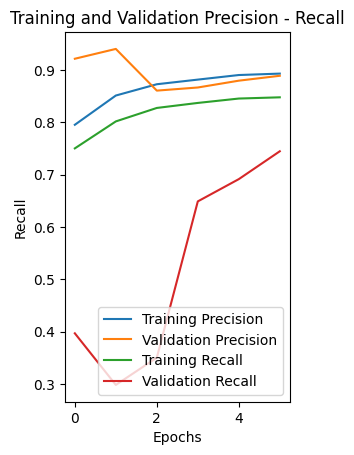

In [56]:
# Precision & Recall plot
plt.subplot(1, 2, 2)

plt.plot(Adam_history.history['precision_2'], label='Training Precision')
plt.plot(Adam_history.history['val_precision_2'], label = 'Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.title('Train vs Validation Loss Per Epoch')


plt.plot(Adam_history.history['recall_2'], label='Training Recall')
plt.plot(Adam_history.history['val_recall_2'], label='Validation Recall')
plt.title('Training and Validation Precision - Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.show()

From the graph above, we can observe that, as we go up the epoch, there was a steady increase in the precision (0.77 - 0.89) and recall (0.73 - 0.84) values for the training data, indicating **very few false positives** predictions. Also, we observed a flunctuating and decreasing precision (0.92 - 0.88) and but marked increase in recall (0.4 - 0.75) reading for the validation data.

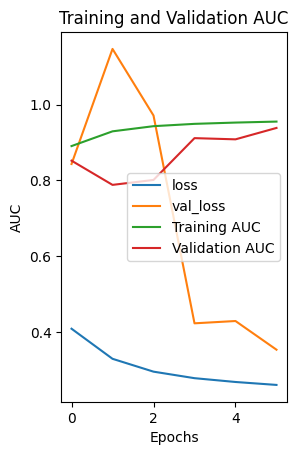

In [57]:
# AUC & Loss plot
plt.subplot(1, 2, 2)

plt.plot(Adam_history.history['loss'], label='loss')
plt.plot(Adam_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Validation Loss Per Epoch')


plt.plot(Adam_history.history['auc_2'], label='Training AUC')
plt.plot(Adam_history.history['val_auc_2'], label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.show()

From the graph above we can see that the **AUC** for both the Training (0.87 - 0.96) and Validation (0.85 - 0.94) which infers that the model is an excellent discriminator between the positive (tumor) and negative (non-tumor) classes.

On the loss curve, we observe a steady decrease (0.45 - 0.26) for the training dataset, while a sharp decrease (0.84 - 0.35) can be seen for the validation data.

In [59]:
test_generator.reset()
label_pred_3 = Adam_model.predict(test_generator)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step


In [60]:
model_pred_df_3 = get_pred_df(df_sample['id'], label_pred_3)
model_pred_df_3

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0
...,...,...
57453,061847314ded6f81e1cd670748bfa2003442c9c7,0
57454,6f3977130212641fd5808210015a609c658dcbff,0
57455,46935f247278539eca74b54d07d666efb528a753,0
57456,a09bcae08a82120183352e0e869181b2911d3dc1,0


In [62]:
# save to csv
model_pred_df_3.to_csv("result_3.csv", index=False)

# Discussion & Conclusion

For our CNN model, we chose a shallow **VGG** architecture and then progressively trained 3 models while tunning some hyperparameters.

**SGD Model**

For the first model we used a **SGD** optimizer, with a `learning-rate` of `0.01`. The metrics showed that the model performed quite well on the training data but didn't perform too well on the recall for validation data and the loss function was also quite hyperhazard in it descent.

**SGD Model 2**

For the second model, due to the loss function performance, we decided to reduce the `learning-rate` to `0.001`. The metrics showed overall better performance on both the test and validation data especially on the recall at `0.80`

**Adam Model**

For this model, we decided to use an advanced optimizer, with a `learning-rate` of `0.001`. The metrics show overall better performance than the previous models with sharp decrease in loss function, high **AUC** and good recall value.

In conclusion, model optimization was very helpful in bringing about a better performing model. For future optimizations we could try the **RMSProp** optimizer and other learning-rate values. 